Мышковец С.А., v.1 13.01.2023

Решение задачи:

Датасет для ДЗ (ID_user1,ID_song,rating) задача предсказать факт взаимодействия (LightFM) и рейтинг (для SVD моделей).



Вывод:
                            
1. Хотя алгоритмы на основе коллаборативных фильтров выдают достаточно информативные рекомендации, есть ощущение, что предсказания все равно больше пальцем в небо. 
            
                                                                                             
2. Явный недостаток модели Surprise.SVD - отсутсвие предсказаний нулевых рейтингов. Параметры из коробки дают лучше результаты, чем подобранные при помощи GridSearchCV.
                                                                                             
                                                                                             
3. Модель LightFM слишком времязатратна, конечный список рекомендаций сомнителен, наличие дополнительной информации (хотя бы названий песен) возможно придало бы реклмендациям большую достоверность.


4. Предсказания двух моделей не совпали.
                                                                                                                                             

---

# Предварительная обработка данных.

Датасет представляет собой информацию рейтинг песен: по 10 оценок от каждого пользователя.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import collections
import warnings
warnings.simplefilter(action='ignore', category=Warning)

**Загружаем данные.**

In [2]:
songs = pd.read_csv("songsDataset.csv", header=0, names=['userID', 'songID', 'rating'])
display(songs.head())

,userID,songID,rating
0,0,7171,5
1,0,8637,4
2,0,21966,4
3,0,35821,5
4,0,82446,5


In [4]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   userID  int64
 1   songID  int64
 2   rating  int64
dtypes: int64(3)
memory usage: 45.8 MB


In [5]:
songs = songs.drop_duplicates()

In [6]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   userID  int64
 1   songID  int64
 2   rating  int64
dtypes: int64(3)
memory usage: 61.0 MB


In [7]:
songs.describe()

,userID,songID,rating
count,2.000000e+06,2.000000e+06,2.000000e+06
mean,9.999950e+04,6.798931e+04,3.459467e+00
std,5.773504e+04,3.940455e+04,1.553719e+00
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.999975e+04,3.424900e+04,2.000000e+00
50%,9.999950e+04,6.779300e+04,4.000000e+00
75%,1.499992e+05,1.019480e+05,5.000000e+00
max,1.999990e+05,1.367350e+05,5.000000e+00


array([[<AxesSubplot:title={'center':'userID'}>,
        <AxesSubplot:title={'center':'songID'}>],
       [<AxesSubplot:title={'center':'rating'}>, <AxesSubplot:>]],
      dtype=object)

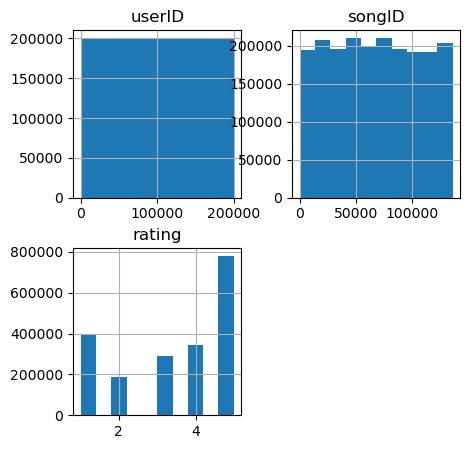

In [8]:
songs.hist(figsize=(5, 5))

In [9]:
songs['rating'].value_counts()

5    780134
1    399243
4    344972
3    287831
2    187820
Name: rating, dtype: int64

In [10]:
songs['songID'].value_counts()

2726      1904
22763     1880
105433    1720
43827     1600
123176    1583
          ... 
53766        1
40112        1
39535        1
20245        1
118866       1
Name: songID, Length: 127771, dtype: int64

In [11]:
songs['userID'].value_counts()

0         10
133350    10
133328    10
133329    10
133330    10
          ..
66668     10
66669     10
66670     10
66671     10
199999    10
Name: userID, Length: 200000, dtype: int64

Дубикатов нет, пустых значений нет.

---

# Surprise

In [11]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import Counter
reader = Reader()

In [113]:
songs.head(3)

,userID,songID,rating
0,0,7171,5
1,0,8637,4
2,0,21966,4


In [114]:
songs.tail(3)

,userID,songID,rating
1999997,199999,116763,1
1999998,199999,128758,1
1999999,199999,129321,1


In [13]:
songs['rating'].mean()

3.459467

In [14]:
songs.columns

Index(['userID', 'songID', 'rating'], dtype='object')

In [15]:
data = Dataset.load_from_df(songs[['userID', 'songID', 'rating']], reader)

In [16]:
%%time 

svd = SVD()
result = cross_validate(svd, data, measures=['RMSE', 'MAE','FCP'],cv=5)

CPU times: user 2min 5s, sys: 1.02 s, total: 2min 6s
Wall time: 2min 6s


In [17]:
result

{'test_rmse': array([1.36894292, 1.36938345, 1.36956391, 1.37011416, 1.37234499]),
 'test_mae': array([1.1582873 , 1.15939785, 1.15967921, 1.15990728, 1.1615186 ]),
 'test_fcp': array([0.52985144, 0.53070433, 0.52897833, 0.52861457, 0.53054851]),
 'fit_time': (16.363473892211914,
  16.872384071350098,
  16.752671003341675,
  17.405555963516235,
  16.42873501777649),
 'test_time': (3.3934261798858643,
  3.05926513671875,
  3.5029380321502686,
  3.3701000213623047,
  3.0920960903167725)}

RMSE мог быть и лучше.

In [18]:
result['test_rmse'].mean()

1.3700698887467422

In [19]:
result['test_mae'].mean()

1.1597580476090328

In [20]:
result['test_fcp'].mean()

0.5297394372226328

Попробуем подобрать лучшие параметры.

In [21]:
from surprise.model_selection import GridSearchCV

In [23]:
param_grid = {"n_epochs": [5, 10, 20], "lr_all": [0.002, 0.005], "reg_all": [0.02, 0,2, 0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

# best MAE score
print(gs.best_score["mae"])

# combination of parameters that gave the best MAE score
print(gs.best_params["mae"])


1.3733708830601845
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}
1.180111416679603
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


Параметры по умолчанию давали лучшие результаты.

Обучим модель на трейне.

In [25]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Посмотрим реальные рейтинги пользователя 1.

In [26]:
songs[songs['userID'] == 1]

,userID,songID,rating
10,1,3342,5
11,1,7522,1
12,1,25363,2
13,1,38997,5
14,1,43685,1
15,1,45488,4
16,1,62770,3
17,1,109450,3
18,1,122506,3
19,1,130621,5


In [117]:
result = svd.predict(uid= 1, iid=3342) # uid =userId;  iid = songID  # r_ui - истинный рейтинг

In [118]:
result

Prediction(uid=1, iid=3342, r_ui=None, est=3.8824467293655993, details={'was_impossible': False})

Сформируем рекомендации для пользователя 1.

In [68]:
fg = []
for i in songs['songID'].unique():
     result = svd.predict(1, i, None)
     fg.append([i,result.est])

In [69]:
fg[:10]

[[7171, 3.411412596189358],
 [8637, 3.2936341731211867],
 [21966, 3.830122955468432],
 [35821, 3.481907216221237],
 [82446, 3.9827558565061336],
 [90409, 2.6690094173229406],
 [107410, 3.9555096820117193],
 [131919, 3.9288189840254972],
 [132685, 3.6634847586836843],
 [136507, 3.819805273968072]]

In [70]:
fg = np.array(fg)

In [73]:
df = pd.DataFrame(fg, columns = ['id','rating_pred'])

In [74]:
df

,id,rating_pred
0,7171.0,3.411413
1,8637.0,3.293634
2,21966.0,3.830123
3,35821.0,3.481907
4,82446.0,3.982756
...,...,...
127766,126606.0,3.242222
127767,60066.0,3.118936
127768,67015.0,3.293162
127769,99648.0,2.892276


Максимальный предсказанный рейтинг для пользователя 1 у песни с id=54626.

In [81]:
df[df['rating_pred'] == df['rating_pred'].max()]

,id,rating_pred
28958,54626.0,4.686465


Минимальный предсказанный рейтинг для пользоватля 1 у песни с id=114291.

In [94]:
df[df['rating_pred'] == df['rating_pred'].min()]

,id,rating_pred
33106,114291.0,1.366456


Найдем 10 песен с максимальным предсказанным рейтингом для пользователя 1.

In [95]:
max_10 = df['rating_pred'].sort_values(ascending=False)[:10]

In [100]:
max_10_lst = []
for i in max_10:
    max_10_lst.append(i)

In [107]:
df_10 = df['rating_pred'].isin(max_10_lst)

In [111]:
df[df_10].sort_values('rating_pred', ascending=False)

,id,rating_pred
28958,54626.0,4.686465
2594,22340.0,4.652648
3017,107814.0,4.650027
37889,65502.0,4.647210
737,38174.0,4.644650
3199,5117.0,4.638390
8196,66732.0,4.637319
1077,129927.0,4.601269
7903,49876.0,4.590400
7581,108975.0,4.585020


**Явный недостаток модели - отсутсвие 0 предсказаний.**

---

# lightfm

In [3]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from lightfm.datasets import fetch_movielens
from lightfm import LightFM
from sklearn import preprocessing
from scipy.sparse import coo_matrix
from scipy import sparse
from scipy.sparse import csr_matrix

In [4]:
songs

,userID,songID,rating
0,0,7171,5
1,0,8637,4
2,0,21966,4
3,0,35821,5
4,0,82446,5
...,...,...,...
1999995,199999,75840,2
1999996,199999,85921,1
1999997,199999,116763,1
1999998,199999,128758,1


Преобразуем датафрейм в разряженную матрицу

In [5]:
from pandas.api.types import CategoricalDtype
from scipy import sparse

users = songs["userID"].unique()
items = songs["songID"].unique()
shape = (len(users), len(items))

# Create indices for users and movies
user_cat = CategoricalDtype(categories=sorted(users), ordered=True)
items_cat = CategoricalDtype(categories=sorted(items), ordered=True)
user_index = songs["userID"].astype(user_cat).cat.codes
item_index = songs["songID"].astype(items_cat).cat.codes

# Conversion via COO matrix
coo = sparse.coo_matrix((songs["rating"], (user_index, item_index)), shape=shape)
csr = coo.tocsr()

In [6]:
csr

<200000x127771 sparse matrix of type '<class 'numpy.int64'>'
	with 2000000 stored elements in Compressed Sparse Row format>

Разделим на трейн и тест.

In [7]:
interactions_train = csr[:100000]

In [8]:
interactions_train

<100000x127771 sparse matrix of type '<class 'numpy.int64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

In [9]:
interactions_test = csr[100000:]

In [10]:
interactions_test

<100000x127771 sparse matrix of type '<class 'numpy.int64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

**Почему размеры train и test должны быть одинаковыми (из stackoverflow.com)?**

Often in ML, the rows are the samples and in this interpretation your single row-sample is a tuple or something similar (user, item, value). The number of rows in test and train surely has no limitation! But there is one in terms of dimensions. So only in terms of dimensions (which users and which items are observed) those datasets need a 1:1 correspondence. That's maybe a strong assumption, but you can imagine the problem predicting user 11, where there was no user 11 in training (there is no latent-vector which was build).

Обучим модель на трейне.

In [11]:
model = LightFM(loss='warp')
model.fit(interactions_train, epochs=30, num_threads=8)

In [12]:
songs[songs['userID'] == 1]

,userID,songID,rating
10,1,3342,5
11,1,7522,1
12,1,25363,2
13,1,38997,5
14,1,43685,1
15,1,45488,4
16,1,62770,3
17,1,109450,3
18,1,122506,3
19,1,130621,5


In [13]:
items = np.array(items)

**Найдем 10 рекомендованных песен для пользователя 1.**

Песни, которые он уже оценил.

In [19]:
known_positives = songs[songs['userID'] == 1]['songID']

In [22]:
known_positives.values

array([  3342,   7522,  25363,  38997,  43685,  45488,  62770, 109450,
       122506, 130621])

Предикты взаимодействия со всеми песнями.

In [23]:
n_users, n_items = interactions_train.shape
scores = model.predict(1, np.arange(n_items))
top_items = items[np.argsort(-scores)]

In [39]:
top_items

array([  4302,  21684, 111721, ...,  14895,  96092,  75882])

Удалим из предиктов оцененные песни.

In [35]:
recommend = []
for i in top_items:
    if i not in known_positives.values:
        recommend.append(i)

In [40]:
recommend[:10]

[4302, 21684, 111721, 9491, 37111, 77498, 10912, 126670, 8573, 73755]

Ни одна рекомендация не совпала с рекомендациями от surprise.SVD:

54626, 22340, 107814, 65502, 38174, 5117, 66732, 129927, 49876, 108975.

Посчитаем метрики precision_at_k и auc_score.

In [41]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [42]:
print("Train precision: %.2f" % precision_at_k(model, interactions_train, k=5).mean())
print("Test precision: %.2f" % precision_at_k(model, interactions_test, k=5).mean())

Train precision: 0.02
Test precision: 0.00


In [43]:
print("Train precision: %.2f" % auc_score(model, interactions_train).mean())
print("Test precision: %.2f" % auc_score(model, interactions_test).mean())

Train precision: 0.97
Test precision: 0.77
